# KNN с использованием LSH

## Импорт библиотек, установка константных значений

In [8]:
import numpy as np

RANDOM_STATE = 42
rng = np.random.default_rng(RANDOM_STATE)

## Генерация данных

Для демонстрации сгенерируем датасет из нормального распределения, где $m$ - число объектов, $n$ - число признаков.

In [9]:
m = 10000
n = 10000

$q$ - вектор запроса (query), для которого мы ищем ближайших соседей.

In [10]:
X = rng.normal(size=(m, n))  # датасет
q = rng.normal(size=n)       # вектор запроса

## Поиск с помощью стандартного KNN

In [11]:
def knn_search(query, data, k=5):

    dists = np.sqrt(np.sum((data - query) ** 2, axis=1))  # вычисляем расстояния от объекта query до всех точек датасета
    inds = np.argsort(dists)  # сортируем по возрастанию расстояний
    inds_k = inds[:k]         # берем top-k точек с наименьшими расстояниями

    return data[inds_k], dists[inds_k]

Найдем 5 ближайших соседей методом KNN.

Также замерим время работы поиска.

In [12]:
%%time

neighbors, dists = knn_search(q, X)
for i, (neighbor, dist) in enumerate(zip(neighbors, dists)):
    print(f"top {i + 1}: dist = {dist}")

top 1: dist = 138.34050497748834
top 2: dist = 138.4023770933504
top 3: dist = 138.49188544864546
top 4: dist = 138.49358974130456
top 5: dist = 138.54917624684813
CPU times: user 263 ms, sys: 167 ms, total: 430 ms
Wall time: 442 ms


## KNN с использованием LSH

Идея метода состоит в том, что:
* Сначала при помощи LSH отбираем объекты, похожие на объект query
* Затем при помощи KNN ищем ближайшие объекты к query только среди похожих, найденных на предыдущем шаге

Используем метод LSH с кодированием при помощи случайных проекций. Он состоит в следующем:
* проводим несколько случайных гиперплоскостей
* для каждой плоскости: для каждого объекта ставим 1, если объект лежит выше плоскости, и 0 иначе
* тогда каждый объект кодируется вектором из 0 и 1, где длина вектора равна числу сгенерированных гиперплоскостей

Объекты похожи, если их кодировки совпадают.

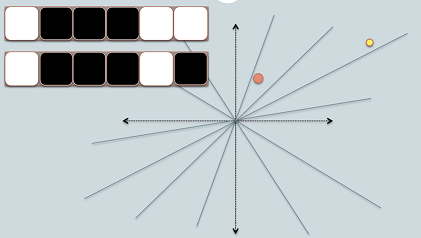

Следующая функция вычисляет количество случайных гиперплоскостей и генерирует их, основываясь на том, сколько в среднем мы хотим получать объектов в одной корзине после хеширования (`bucket_size`).

In [13]:
def generate_hyperplanes(data, bucket_size=16):
    m = data.shape[0]            # число объектов
    n = data.shape[1]            # число признаков
    b = m // bucket_size         # количество корзин
    h = int(np.log2(b))          # количество гиперплоскостей
    H = rng.normal(size=(h, n))  # гиперплоскости, заданные своими нормалями
    return H

Следующая функция хеширует данные, основываясь на полученных гиперплоскостях, то есть кодирует объект вектором из 0 и 1.

Затем для удобства функция переводит вектор в число путем перевода из двоичной системы в десятичную.

Например: $[0, 1, 1, 0] \to 0 \cdot 1 + 1 \cdot 2 + 1 \cdot 4 + 0 \cdot 8 = 6$

Между двоичной и десятичной записью взаимно однозначное соответствие, но десятичная запись удобнее.  
По сути полученное число - это номер корзины, в которую попадает объект.

In [14]:
def hamming_hash(data, hyperplanes):
    b = len(hyperplanes)
    hash_key = (data @ hyperplanes.T) >= 0

    dec_vals = np.array([2 ** i for i in range(b)], dtype=int)
    hash_key = hash_key @ dec_vals

    return hash_key

Теперь мы умеем по каждому объекту определять номер корзины, в которую он попадает.

Функция ниже создает словарь, где для каждой корзины содержатся элементы выборки, попадающие в эту корзину  
(эта структура называется *хеш-таблицей*).

In [15]:
def locality_sensitive_hash(data, hyperplanes):
    hash_vals = hamming_hash(data, hyperplanes)
    hash_table = {}
    for i, v in enumerate(hash_vals):
        if v not in hash_table:
            hash_table[v] = set()
        hash_table[v].add(i)

    return hash_table

Посмотрим, как работают описанные функции.

In [16]:
hyperplanes = generate_hyperplanes(X)

print('num planes:',len(hyperplanes))
print('normal vector to 1st plane:',hyperplanes[0])

num planes: 9
normal vector to 1st plane: [ 0.0767168   0.67027124 -1.0879874  ...  0.85808069  2.17378794
  1.26858972]


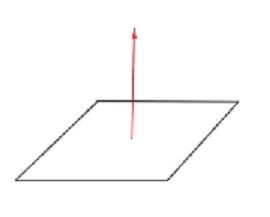

In [17]:
hamming_hash(q, hyperplanes)

336

In [18]:
hash_table = locality_sensitive_hash(X, hyperplanes)
hash_table

{354: {0,
  344,
  1785,
  2663,
  3653,
  4047,
  4883,
  5452,
  5645,
  5783,
  6040,
  6292,
  8538,
  8608,
  9632},
 240: {1,
  314,
  315,
  692,
  1464,
  1937,
  2323,
  2606,
  3416,
  3509,
  3694,
  3894,
  3993,
  4201,
  5951,
  6779,
  7473,
  7683,
  8689,
  8783,
  9368,
  9589,
  9664},
 50: {2,
  1099,
  1396,
  1609,
  2590,
  2619,
  4739,
  5288,
  5565,
  5793,
  6450,
  7236,
  8247,
  8348,
  8412,
  8550,
  9400,
  9414},
 141: {3,
  145,
  1591,
  1611,
  2091,
  2208,
  2577,
  2730,
  3304,
  4237,
  5854,
  6152,
  6322,
  7169,
  7780,
  7973,
  9147,
  9405},
 436: {4,
  273,
  448,
  950,
  1367,
  1476,
  1851,
  2304,
  3181,
  3414,
  3589,
  3848,
  4385,
  5396,
  5914,
  6159,
  6578,
  6773,
  6815,
  7996,
  8002,
  8889,
  9111},
 456: {5,
  482,
  1400,
  1459,
  1835,
  1840,
  2165,
  2380,
  2512,
  2548,
  3033,
  3383,
  3644,
  3720,
  4613,
  4750,
  5970,
  6233,
  6287,
  6816,
  7053,
  7123,
  7239,
  8389},
 398: {6,
  821,
  1111,

Теперь реализуем алгоритм поиска KNN с использованием LSH:
* Сначала при помощи LSH отбираем объекты, похожие на объект query
* Затем при помощи KNN ищем ближайшие объекты к query только среди похожих, найденных на предыдущем шаге

In [19]:
def approx_knn_search(query, data, k=5, bucket_size=16):
    candidates = set()

    hyperplanes = generate_hyperplanes(data)
    hash_table = locality_sensitive_hash(data, hyperplanes) # формируем хеш-таблицу по датасету

    query_hash = hamming_hash(query, hyperplanes)
    if query_hash in hash_table:
        candidates = candidates.union(hash_table[query_hash])
    candidates = np.stack([data[i] for i in candidates], axis=0) # находим кандидатов = объекты, попадающие с query в одну корзину

    return knn_search(query, candidates, k=k) # с помощью KNN ищем ближайших соседей только из найденных кандидатов

In [20]:
%%time

neighbors, dists = approx_knn_search(q, X)

for i, (neighbor, dist) in enumerate(zip(neighbors, dists)):
    print(f"top {i + 1}: dist = {dist}")

top 1: dist = 139.3507551255081
top 2: dist = 139.985269991532
top 3: dist = 140.28348419444504
top 4: dist = 140.4165365346994
top 5: dist = 140.49107910459307
CPU times: user 363 ms, sys: 19 ms, total: 382 ms
Wall time: 201 ms
